In [1]:
import sys
from pathlib import Path
from os.path  import join
from src.config import DATA_DIR, CONFIG_DIR, MODELS_DIR
from omegaconf import OmegaConf
from src.external.hptr.src.data_modules.agent_centric import AgentCentricPreProcessing
from src.external.hptr.src.data_modules.ac_global import AgentCentricGlobal
from src.mimolm import InputProjections, EarlyFusionEncoder, MotionDecoder
import torch
import torch.nn.functional as F
import lightning as pl
from collections import OrderedDict
import torch.nn as nn
from tqdm import tqdm
import numpy as np

# Add the project root to sys.path
project_root = Path().resolve().parent  # Adjust as needed to point to the root folder
sys.path.append(str(project_root))

print(Path.cwd())  # Check if the path is added

2025-02-16 16:56:14.103 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/harshavardhan-patil/Work/Projects/mimolm


/home/harshavardhan-patil/Work/Projects/mimolm/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/harshavardhan-patil/Work/Projects/mimolm/notebooks


In [2]:
from src.external.hptr.src.data_modules.data_h5_av2 import DataH5av2
from src.mimolm import MimoLM
from lightning.pytorch.callbacks import LearningRateMonitor

torch.set_printoptions(threshold=10000, sci_mode=False)
data_module = DataH5av2(DATA_DIR)
data_module.setup(stage="fit")
train_loader = data_module.train_dataloader()
# val_loader = data_module.val_dataloader()

preprocessor = nn.Sequential(OrderedDict([
            ('pre_1', AgentCentricPreProcessing(sampling_rate = 5,
                                        time_step_current=49, 
                                        n_target=12,
                                        n_other=48,
                                        n_map=512,
                                        mask_invalid=False)),
            ('pre_2', AgentCentricGlobal(sampling_rate = 5,
                                data_size=data_module.tensor_size_train,
                               time_step_current=49,
                                dropout_p_history=0.1, 
                                add_ohe=True,
                                pl_aggr=False,
                                pose_pe= {"agent": "xy_dir",
                                        "map": "mpa_pl"}))
                                        ]))

decoder = MotionDecoder(max_delta = 2.0, #meters
                                n_quantization_bins = 128,
                                n_verlet_steps = 13,
                                emb_dim = 256,
                                enc_dim = 128,
                                sampling_rate = 5,
                                n_time_steps = 110,
                                n_target = 5, #should be same as AgentCentricProcessing
                                time_step_end = 49,
                                dropout_rate = 0.2,
                                n_rollouts = 1,
                                n_heads = 2,
                                n_layers = 2,)

def tokenize_motion(motion_tokens, pos_bins, verlet_wrapper, n_verlet_steps):
    # delta_x and delta_y
    motion_tokens = torch.diff(motion_tokens, dim=2, prepend=motion_tokens[:, :, :1, :])
    # for masking transitional diffs
    invalid_indices = torch.cat(((motion_tokens < -8.0).nonzero()
                                 , (motion_tokens > 8.0).nonzero()
                                 , (motion_tokens == 0.).nonzero())) # == 0. only for bin generation 
    
    # MotionLM uses greedy search, using bucketize here for simplicity
    x_tokens = torch.bucketize(motion_tokens[:, :, :, 0].contiguous(), pos_bins,)
    y_tokens = torch.bucketize(motion_tokens[:, :, :, 1].contiguous(), pos_bins,)
    x_last = x_tokens[:, :, -1].unsqueeze(-1)
    y_last = y_tokens[:, :, -1].unsqueeze(-1)
    x_tokens_diff = torch.diff(x_tokens, dim=2, prepend = x_tokens[:, :, :1])
    y_tokens_diff = torch.diff(y_tokens, dim=2, prepend = y_tokens[:, :, :1])
    # Verlet Wrapper (see paper): The idea is that velocity of cars changes smoothly, 
    # so we can use a smaller vocabulary to represent the relative motion between the last two time steps.
    # e.g: max_delta: float = 4.0,  n_quantization_bins: int = 128,  n_verlet_steps: int = 13, 10 Hz predicition, 
    # the max speed for the modeled agent is 4 x 10 = 40 m/s. 
    # 0 to max steps in Verlet Wrapper represents the max distance delta modeled. 
    # THIS IS NO LONGER THE CASE WITH NON-UNIFORM BINS 
    # For -6 to 6 with 13 steps in Verlet and for 128 bins, the max acceleration between timesteps is 3.1 m/s^2.
    x_tokens = torch.clamp(torch.bucketize(x_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    y_tokens = torch.clamp(torch.bucketize(y_tokens_diff, verlet_wrapper,), min = 0, max = n_verlet_steps - 1)
    mask = torch.ones_like(motion_tokens, dtype=bool)
    mask[invalid_indices[:, 0], invalid_indices[:, 1], invalid_indices[:, 2]] = 0.
    # collapse the per-coordinate actions to a single integer indexing into their Cartesian product
    cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens) 
    # invalid tokens
    cart_prod[invalid_indices[:, 0], invalid_indices[:, 1], invalid_indices[:, 2]] = n_verlet_steps ** 2
    cart_prod[:, :, :1] = n_verlet_steps ** 2
    return cart_prod, torch.cat((x_last, y_last), dim=-1), motion_tokens[mask]

In [ ]:
verlet_indices = torch.tensor([0] * 170)
motion_diffs = []
i = 0
inds = None
for batch in tqdm(train_loader):
    batch = preprocessor(batch)
    a = torch.cat((batch["ac/target_pos"], batch["gt/pos"][:, :, ::2,]), dim = -2)
    actuals, _, diff = tokenize_motion(a,
                decoder.pos_bins,
                decoder.verlet_wrapper, 
                decoder.n_verlet_steps)
    actuals[:, :, :decoder.step_current][~batch['input/target_valid']] = decoder.n_verlet_steps ** 2
    actuals = actuals.flatten(0, -1)
    verlet_indices += np.bincount(actuals, minlength=170)
    motion_diffs.extend(diff.tolist())
    break

  0%|          | 0/1562 [00:00<?, ?it/s]/tmp/ipykernel_9379/3785995113.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens)
/tmp/ipykernel_9379/3565751573.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  verlet_indices += np.bincount(actuals, minlength=170)
100%|██████████| 1562/1562 [52:23<00:00,  2.01s/it]


In [ ]:
data = motion_diffs

summary = {
    "Min": float(np.min(data)),
    "Max": float(np.max(data)),
    "Mean": float(np.mean(data)),
    "Median": float(np.median(data)),
    "Std Dev": float(np.std(data)),
    "10th Percentile": float(np.percentile(data, 10)),
    "25th Percentile (Q1)": float(np.percentile(data, 25)),
    "50th Percentile (Median)": float(np.percentile(data, 50)),
    "75th Percentile (Q3)": float(np.percentile(data, 75)),
    "90th Percentile": float(np.percentile(data, 90)),
    "99th Percentile": float(np.percentile(data, 99)),
}

summary
# {'Min': -7.9998698234558105,
#  'Max': 7.999887943267822,
#  'Mean': 0.3238078189874087,
#  'Median': 0.002700429642572999,
#  'Std Dev': 0.769892570401297,
#  '10th Percentile': -0.036982059478759766,
#  '25th Percentile (Q1)': -0.0044559057569131255,
#  '50th Percentile (Median)': 0.002700429642572999,
#  '75th Percentile (Q3)': 0.13794898986816406,
#  '90th Percentile': 1.5481891632080078,
#  '99th Percentile': 3.1614227294921875}

{'Min': -7.9998698234558105,
 'Max': 7.999887943267822,
 'Mean': 0.3238078189874087,
 'Median': 0.002700429642572999,
 'Std Dev': 0.769892570401297,
 '10th Percentile': -0.036982059478759766,
 '25th Percentile (Q1)': -0.0044559057569131255,
 '50th Percentile (Median)': 0.002700429642572999,
 '75th Percentile (Q3)': 0.13794898986816406,
 '90th Percentile': 1.5481891632080078,
 '99th Percentile': 3.1614227294921875}

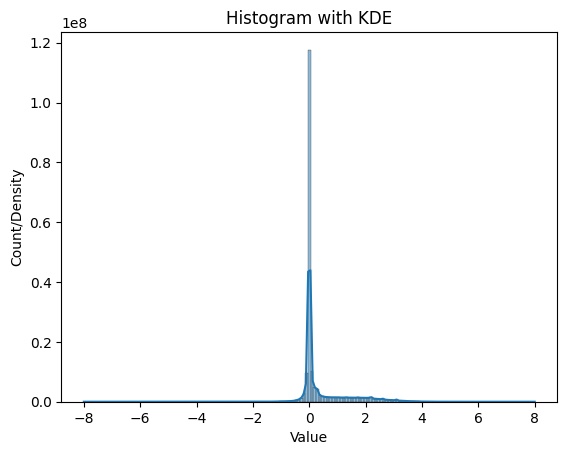

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(np.clip(data, -8.0, 8.0), bins=169, kde=True)

plt.xlabel("Value")
plt.ylabel("Count/Density")
plt.title("Histogram with KDE")

plt.show()


In [ ]:
np.savetxt("diff_data_5hz.txt", data, fmt="%.2f")

In [13]:
torch.quantile(torch.tensor([data]), torch.linspace(0, 1, steps=128))

RuntimeError: quantile() input tensor is too large

In [ ]:
np.set_printoptions()
np.quantile(data, np.linspace(0, 1, num=128))

array([-7.99986982e+00, -4.80515516e-01, -2.90285110e-01, -2.07447052e-01,
       -1.59583569e-01, -1.27577724e-01, -1.04294774e-01, -8.67421402e-02,
       -7.30916895e-02, -6.22835159e-02, -5.35616875e-02, -4.64320183e-02,
       -4.05269618e-02, -3.55925560e-02, -3.14068198e-02, -2.78291702e-02,
       -2.47572687e-02, -2.20771438e-02, -1.97351646e-02, -1.76718980e-02,
       -1.58494115e-02, -1.42278671e-02, -1.27836357e-02, -1.14975572e-02,
       -1.03395581e-02, -9.29996371e-03, -8.36381689e-03, -7.51924515e-03,
       -6.75643329e-03, -6.05793297e-03, -5.42628765e-03, -4.85761165e-03,
       -4.33536619e-03, -3.85799213e-03, -3.41749191e-03, -3.01334262e-03,
       -2.64929608e-03, -2.31454521e-03, -1.99968368e-03, -1.72257423e-03,
       -1.46495062e-03, -1.22833711e-03, -1.01258140e-03, -8.32785008e-04,
       -6.54524192e-04, -4.97348440e-04, -3.70107591e-04, -2.43315590e-04,
       -1.31397753e-04, -4.13954258e-05,  5.31226397e-06,  8.01086426e-05,
        1.87076628e-04,  

In [6]:
verlet_indices

tensor([ 2421063,   307552,   388406,   509306,   657673,   785484,   948522,
          787378,   653729,   493817,   387046,   302467,  2344400,   259443,
           51518,    68708,    97274,   140132,   162449,   200444,   170620,
          135803,    94318,    66714,    49205,   251386,   333557,    67576,
           93145,   131625,   189534,   227577,   289082,   237817,   181961,
          126950,    88830,    64746,   322328,   448522,    90924,   125940,
          184066,   270554,   338778,   444570,   348152,   260014,   176264,
          123854,    88776,   430488,   646546,   130227,   181273,   272269,
          408209,   546178,   778411,   553712,   390665,   256478,   173335,
          124881,   622577,  1279849,   239921,   334274,   496138,   781027,
         1281047,  2100955,  1318401,   774729,   482150,   325870,   231766,
         1235521,  2795222,   504507,   709730,  1062941,  1753484,  3257395,
         6493248,  3344946,  1820945,  1067714,   710567,   4996

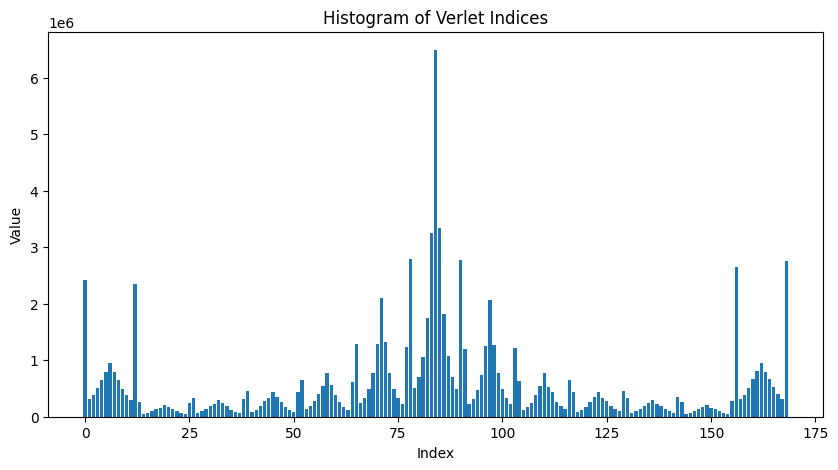

In [18]:
plt.figure(figsize=(10, 5))
plt.bar(torch.arange(len(verlet_indices) - 1), verlet_indices[:-1])

# Labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Histogram of Verlet Indices")

# Show the plot
plt.show()

In [3]:
verlet_indices = torch.tensor([0] * 170)
motion_diffs = []
i = 0
v = None
for batch in tqdm(train_loader):
    batch = preprocessor(batch)
    v = batch['input/target_valid']
    a = torch.cat((batch["ac/target_pos"], batch["gt/pos"][:, :, ::2,]), dim = -2)
    actuals, _, diff = tokenize_motion(a,
                decoder.pos_bins, 
                decoder.verlet_wrapper, 
                decoder.n_verlet_steps,)
    b = actuals
    actuals[:, :, :decoder.step_current][~batch['input/target_valid']] = decoder.n_verlet_steps ** 2
    b = actuals
    actuals = actuals.flatten(0, -1)
    verlet_indices += np.bincount(actuals, minlength=170)
    motion_diffs.extend(diff.tolist())
    x = diff
    if not v[v.any(dim=-1)][ :, -1].all():
        print('broken')
        break
    if i == 0:
        break
   
 

  0%|          | 0/199908 [00:00<?, ?it/s]/tmp/ipykernel_22966/3785995113.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cart_prod = torch.tensor(x_tokens * n_verlet_steps + y_tokens)
/tmp/ipykernel_22966/1479553418.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  verlet_indices += np.bincount(actuals, minlength=170)
  0%|          | 0/199908 [00:00<?, ?it/s]


In [5]:
v.shape

torch.Size([1, 12, 25])

In [22]:
b

tensor([[[169, 162, 162,  ...,  58,   6,   6],
         [169, 162, 162,  ...,  84,   6,   6],
         [169, 162, 162,  ...,  57,   6,   6],
         ...,
         [169, 169, 169,  ...,  84,  84,  84],
         [169, 169, 169,  ...,  84,  84,  84],
         [169, 169, 169,  ...,  84,  84,  84]],

        [[169, 164, 163,  ...,  85,  84,  71],
         [169, 162, 161,  ...,  44,   6,   6],
         [169, 169, 169,  ...,  84,  32,   6],
         ...,
         [169, 169, 169,  ..., 169, 169, 169],
         [169, 163, 161,  ...,  32,   6,   6],
         [169, 169, 169,  ..., 169, 169, 169]],

        [[169, 169, 169,  ...,  58,  58,  45],
         [169,  84,  84,  ...,  70,  71,  58],
         [169,  84,  84,  ...,  84,  58,  45],
         ...,
         [169,  84,  84,  ...,  84,  84,  84],
         [169, 169, 169,  ..., 169, 169, 169],
         [169, 169, 169,  ...,   5,   6,   4]],

        ...,

        [[169, 165, 163,  ...,  84,  84,  84],
         [169,  84,  84,  ...,  84,  84,  84]

In [23]:
a

tensor([[[[   -29.3771,     -0.0230],
          [   -28.6057,     -0.0245],
          [   -27.5283,     -0.0250],
          ...,
          [    34.9153,     -0.4322],
          [    36.2796,     -0.4082],
          [    37.3282,     -0.3851]],

         [[   -41.7672,     -0.1353],
          [   -40.6539,     -0.1257],
          [   -39.0936,     -0.1125],
          ...,
          [    48.9181,     -0.5305],
          [    50.7108,     -0.5242],
          [    52.0847,     -0.5197]],

         [[   -42.1550,      0.2879],
          [   -41.1284,      0.2879],
          [   -39.6953,      0.2844],
          ...,
          [    46.7703,      1.1064],
          [    48.1070,      1.1461],
          [    49.1372,      1.1783]],

         ...,

         [[   -46.3538,     -1.3729],
          [   -46.3538,     -1.3729],
          [   -46.3538,     -1.3729],
          ...,
          [     0.1182,      0.0418],
          [     0.1504,      0.0444],
          [     0.1738,      0.0461]],

     

In [15]:
a

tensor([[[[  20.7997,   30.4386],
          [ -42.7161,    5.1916],
          [  26.8506,   35.0742],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[  20.4423,   30.2860],
          [ -43.3839,    4.8765],
          [  26.5564,   34.9151],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[  19.9977,   30.0976],
          [ -44.2437,    4.4706],
          [  26.1876,   34.7147],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         ...,

         [[ -57.2254,   -0.7752],
          [   0.0000,    0.0000],
          [-100.4531,  -23.4945],
          ...,
          [   0.0000,    0.0000],
          [   0.0000,    0.0000],
          [   0.0000,    0.0000]],

         [[ -57.6910,   -0.9831],
          [   0.0000,    0.0000],
          [-101.2876,  -23.8528],

In [ ]:
np.linalg.norm([[     9.4798,     -0.2392],
          [   137.8498,     16.3927],])

np.float64(139.14457157219607)

In [28]:
(a == 137.8498).nonzero(as_tuple=True)

(tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64),
 tensor([], dtype=torch.int64))